In [25]:
# !pip install wordcloud

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import xgboost as xgb
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [3]:
train = pd.read_csv('train.csv')
train.shape

(182080, 16)

In [4]:
test = pd.read_csv('test.csv')
test.shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(78035, 15)

In [5]:
resource = pd.read_csv('resources.csv')
resource.shape

(1541272, 4)

In [6]:
resource.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [7]:
train.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1


# EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [9]:
train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'], errors='coerce')
print('Projests before 2016-05-17:', np.sum(train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7)))
print('Projests after 2016-05-17:', np.sum(train.project_submitted_datetime.dt.date >= datetime.date(2016, 5, 7)))

Projests before 2016-05-17: 3751
Projests after 2016-05-17: 178329


In [10]:
train.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [11]:
train.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,My students need the 3doodler. We are an SEM s...,5,1


In [15]:
train_test = train[['project_essay_1','project_essay_2']]

In [31]:
# project_essay_1

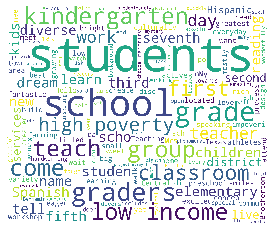

In [29]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=None,
                          background_color='white',
                          stopwords=stopwords,
                          random_state=42,width=3600, height=3000
                         ).generate(str(train['project_essay_1']))

print(wordcloud)
fig = plt.figure(15)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [32]:
# project_essay_2

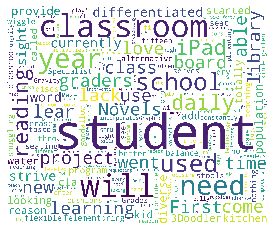

In [30]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=None,
                          background_color='white',
                          stopwords=stopwords,
                          random_state=42,width=3600, height=3000
                         ).generate(str(train['project_essay_2']))

print(wordcloud)
fig = plt.figure(15)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [33]:
# project_resource_summary

In [38]:
train[~train.project_resource_summary.str.contains('My students need')]['project_resource_summary']

80740    I need a dash cam to protect myself and studen...
82271     I need smaller tables for guided reading groups.
Name: project_resource_summary, dtype: object

In [39]:
train.project_resource_summary[train.project_resource_summary.str.contains('My students need') == False].values

array(['I need a dash cam to protect myself and students in case of an accident and to also use as a teaching tool in the classroom.',
       'I need smaller tables for guided reading groups.'], dtype=object)

In [45]:
# teacher_prefix

In [47]:
pd.crosstab(train.teacher_prefix, train.project_is_approved, dropna=False, normalize='index')

project_is_approved,0,1
teacher_prefix,,
Dr.,0.192308,0.807692
Mr.,0.157978,0.842022
Mrs.,0.145915,0.854085
Ms.,0.156948,0.843052
Teacher,0.205777,0.794223


In [49]:
train.teacher_prefix.value_counts()

Mrs.       95405
Ms.        65066
Mr.        17667
Teacher     3912
Dr.           26
Name: teacher_prefix, dtype: int64

In [51]:
## school state

In [56]:
train.groupby('school_state').agg({'project_is_approved': ['mean', 'count']}).reset_index().sort_values([('project_is_approved', 'mean')], ascending=False).reset_index(drop=True)

school_state project_is_approved       
                               mean  count
0            DE            0.891341    589
1            WY            0.875706    177
2            OH            0.871467   4139
3            CT            0.871294   2766
4            WA            0.868050   3903
5            WV            0.867700    839
6            NH            0.867121    587
7            ND            0.866935    248
8            SC            0.864923   6463
9            SD            0.862348    494
10           MA            0.860138   4054
11           ME            0.858525    827
12           KY            0.857735   2172
13           MO            0.857547   4247
14           MN            0.857421   2055
15           NV            0.856770   2297
16           CA            0.856431  25695
17           OR            0.855592   2119
18           VA            0.855194   3446
19           IL            0.853792   7332
20           NY            0.853582  12157
21           NC            0.853480   8463
22           KS            0.852830   1060
23           PA            0.852543   5093
24           NE            0.851927    493
25           TN            0.851904   2836
26           AK            0.849192    557
27           VT            0.848921    139
28           AL            0.848393   2955
29           IN            0.847937   4314
30           IA            0.846154   1079
31           CO            0.845787   1887
32           WI            0.845122   2983
33           MI            0.844478   5324
34           RI            0.844211    475
35           HI            0.843498    869
36           MS            0.843384   2222
37           NJ            0.843367   3671
38           ID            0.841869   1113
39           AZ            0.841727   3614
40           MD            0.836290   2480
41           UT            0.835110   2814
42           OK            0.834422   3829
43           GA            0.834087   6636
44           LA            0.834009   3946
45           AR            0.832100   1757
46           MT            0.828125    384
47           FL            0.824500  10359
48           NM            0.822052    916
49           TX            0.815670  12304
50           DC            0.812639    902

# Feature Engineering

In [57]:
## Categorical data

There are four columns with categorical data: teacher_prefix, project_grade_category,school_state. First two of them have little number of unique values, so we can use one hot encoding for them.

In [60]:
train = pd.concat([train,
                   pd.get_dummies(train['teacher_prefix'], drop_first=True),
                   pd.get_dummies(train['project_grade_category'], drop_first=True)], axis=1)
train.drop(['teacher_prefix', 'project_grade_category'], axis=1, inplace=True)

test = pd.concat([test,
                   pd.get_dummies(test['teacher_prefix'], drop_first=True),
                   pd.get_dummies(test['project_grade_category'], drop_first=True)], axis=1)
test.drop(['teacher_prefix', 'project_grade_category'], axis=1, inplace=True)

In [61]:
## Text data

let's create new features based on texts: length of text (symbols) and number of words.

In [62]:
train['len_project_subject_categories'] = train['project_subject_categories'].apply(lambda x: len(x))
train['len_project_subject_subcategories'] = train['project_subject_subcategories'].apply(lambda x: len(x))